In [333]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import (
    Input,
    Sequential,
    layers,
    callbacks,
    optimizers,
)
from conlanger.models.WGANGP import WGANGP
from conlanger.utils import display_rows, get_closest_matches, get_exact_matches_indices
from IPython.display import display



In [334]:
USE_GPU = True
TRAIN = True

In [335]:
tf.test.gpu_device_name()

if USE_GPU:
    with tf.device('/gpu:0'):
        gpu = tf.config.list_physical_devices("GPU")
        if not gpu:
            raise

I0000 00:00:1726592086.927532    4400 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726592086.929256    4400 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726592086.930737    4400 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726592086.932442    4400 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [336]:
IMAGE_SIZE = 14
CHANNELS = 1
BATCH_SIZE = 16
Z_DIM = IMAGE_SIZE * IMAGE_SIZE
CRITIC_LEARNING_RATE = 0.00001
GENERATOR_LEARNING_RATE = 0.00001
EPOCHS = 150
CRITIC_STEPS = 6
GP_WEIGHT = 9.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
NUM_LANGS = 100
STEPS_PER_EPOCH = 5
REPEAT_DATA = 3

In [337]:
data = np.load("./data/language_parameters.npz", allow_pickle=True)
language_parameters = data["language_parameters"]
languages = data["languages"]
parameters = data["parameters"]

l = language_parameters.shape[0]

X = np.hstack([language_parameters.copy(), np.zeros((l, 8))]).reshape(l, IMAGE_SIZE, IMAGE_SIZE)
X = np.expand_dims(X, axis=3)

MAX_VALUE = X.max()

X /= MAX_VALUE

assert language_parameters.shape[0] == languages.shape[0]

language_parameters.shape, languages.shape, parameters.shape, X.shape, Z_DIM

((1021, 188), (1021, 2), (188, 2), (1021, 14, 14, 1), 196)

In [338]:
critic = Sequential(
    [
        Input(shape=X.shape[1:]),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 8, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * IMAGE_SIZE, kernel_size=2, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
    ],
    name="critic",
)
critic.summary()

Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_198 (Conv2D)             │ (None, 7, 7, 14)       │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_220 (LeakyReLU)     │ (None, 7, 7, 14)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_199 (Conv2D)             │ (None, 4, 4, 28)       │         3,556 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_221 (LeakyReLU)     │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_176 (Dropout)           │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_200 (Conv2D)             │ (None, 2, 2, 56)       │        14,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_222 (LeakyReLU)     │ (None, 2, 2, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_177 (Dropout)           │ (None, 2, 2, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_201 (Conv2D)             │ (None, 1, 1, 112)      │        56,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_223 (LeakyReLU)     │ (None, 1, 1, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_178 (Dropout)           │ (None, 1, 1, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_202 (Conv2D)             │ (None, 1, 1, 196)      │        88,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_224 (LeakyReLU)     │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_179 (Dropout)           │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 196)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,428 (634.48 KB)

 Trainable params: 162,428 (634.48 KB)

 Non-trainable params: 0 (0.00 B)

In [339]:
generator = Sequential(
    [
        Input(shape=(Z_DIM,)),
        layers.Reshape((1, 1, Z_DIM)),
        layers.Conv2DTranspose(
            IMAGE_SIZE * IMAGE_SIZE, kernel_size=4, strides=2, padding="valid", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 8, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 4, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=2, strides=4, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * IMAGE_SIZE, kernel_size=8, strides=1, padding="same", activation="sigmoid"
        ),
        layers.Reshape(X.shape[1:]),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_44 (Reshape)            │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_110            │ (None, 4, 4, 196)      │       614,656 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_180 (Dropout)           │ (None, 4, 4, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_203 (Conv2D)             │ (None, 2, 2, 112)      │       351,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 2, 2, 112)      │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_225 (LeakyReLU)     │ (None, 2, 2, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_181 (Dropout)           │ (None, 2, 2, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_204 (Conv2D)             │ (None, 1, 1, 56)       │       100,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 1, 1, 56)       │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_226 (LeakyReLU)     │ (None, 1, 1, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_111            │ (None, 2, 2, 28)       │        25,088 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_227 (LeakyReLU)     │ (None, 2, 2, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_112            │ (None, 4, 4, 28)       │         3,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_182 (Dropout)           │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_205 (Conv2D)             │ (None, 2, 2, 28)       │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 2, 2, 28)       │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_228 (LeakyReLU)     │ (None, 2, 2, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_113            │ (None, 4, 4, 28)       │         3,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_183 (Dropout)           │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_206 (Conv2D)             │ (None, 1, 1, 56)       │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_91          │ (None, 1, 1, 56)       │           224 │
│ (BatchNormalization)            │                        │             

 Total params: 1,810,676 (6.91 MB)

 Trainable params: 1,810,172 (6.91 MB)

 Non-trainable params: 504 (1.97 KB)

In [340]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [341]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=CRITIC_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=GENERATOR_LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [342]:
import matplotlib.pyplot as plt


class ImageGenerator(callbacks.Callback):
    def __init__(self, latent_dim, num_img=10, display_on_epoch=10, figsize=(28, 28)):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.display_on_epoch = display_on_epoch
        self.figsize = figsize

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.display_on_epoch == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors).numpy()
            plt.figure(figsize=self.figsize)

            for i in range(self.num_img):
                _ = plt.subplot(1, self.num_img, i + 1)
                plt.imshow(generated_images[i].astype("float32"), cmap="copper_r")
                plt.axis("off")
            
            plt.show()

Epoch 1/150


2024-09-17 17:55:40.122636: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_subtract_fusion', 8 bytes spill stores, 24 bytes spill loads



3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - c_gp: 0.3348 - c_loss: 3.0161 - c_wass_loss: 0.0027 - g_loss: -0.0036 

/home/pappa/anaconda3/envs/conlanger/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


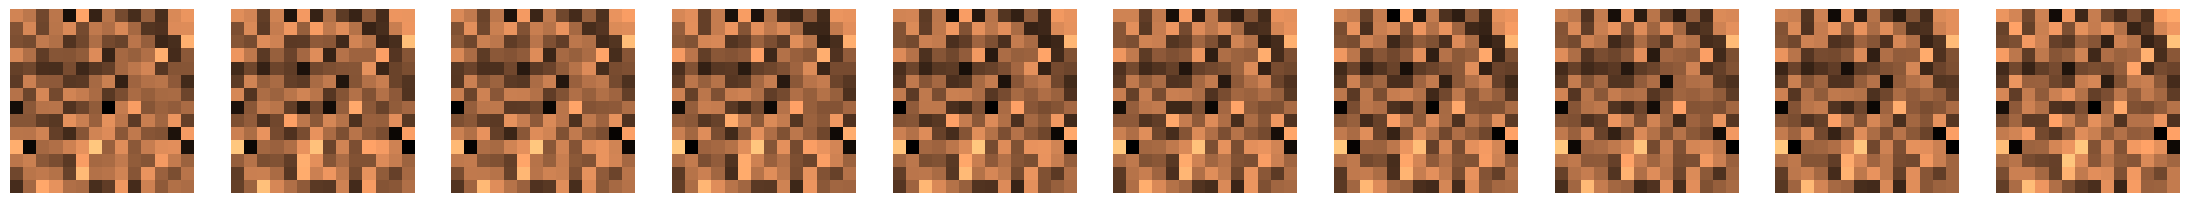

5/5 ━━━━━━━━━━━━━━━━━━━━ 52s 48ms/step - c_gp: 0.3136 - c_loss: 2.8254 - c_wass_loss: 0.0028 - g_loss: -0.0037
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0698 - c_loss: 0.6323 - c_wass_loss: 0.0044 - g_loss: -0.0062
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_gp: 0.0446 - c_loss: 0.4055 - c_wass_loss: 0.0037 - g_loss: -0.0061
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_gp: 0.0354 - c_loss: 0.3204 - c_wass_loss: 0.0018 - g_loss: -0.0049
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_gp: 0.0283 - c_loss: 0.2553 - c_wass_loss: 3.1567e-04 - g_loss: -0.0042
Epoch 6/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - c_gp: 0.0270 - c_loss: 0.2425 - c_wass_loss: -3.6313e-04 - g_loss: -0.0040

2024-09-17 17:55:41.385575: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15979104858406314539


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - c_gp: 0.0265 - c_loss: 0.2375 - c_wass_loss: -5.8877e-04 - g_loss: -0.0039
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_gp: 0.0238 - c_loss: 0.2133 - c_wass_loss: -0.0013 - g_loss: -0.0039
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_gp: 0.0216 - c_loss: 0.1922 - c_wass_loss: -0.0018 - g_loss: -0.0039
Epoch 9/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0215 - c_loss: 0.1911 - c_wass_loss: -0.0023 - g_loss: -0.0040
Epoch 10/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0210 - c_loss: 0.1863 - c_wass_loss: -0.0028 - g_loss: -0.0041
Epoch 11/150
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - c_gp: 0.0200 - c_loss: 0.1764 - c_wass_loss: -0.0032 - g_loss: -0.0041

2024-09-17 17:55:42.284376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15979104858406314539


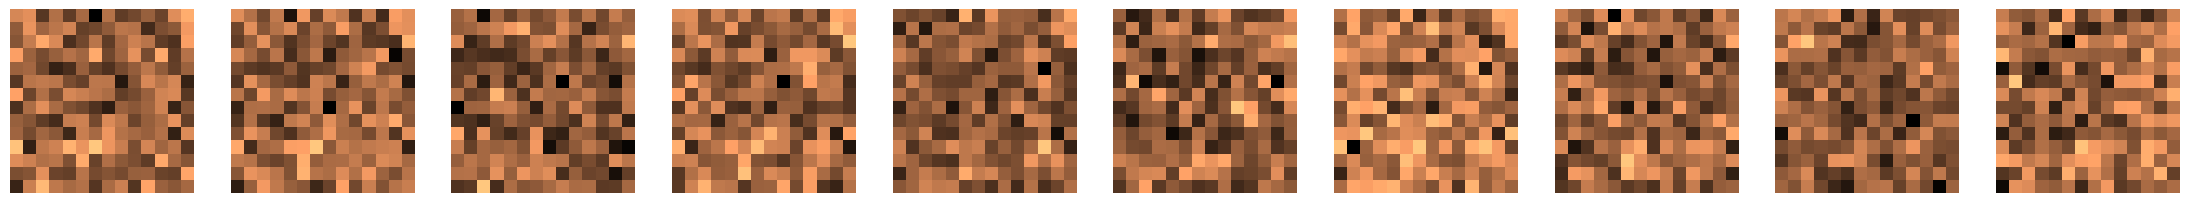

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - c_gp: 0.0198 - c_loss: 0.1749 - c_wass_loss: -0.0032 - g_loss: -0.0041
Epoch 12/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0192 - c_loss: 0.1695 - c_wass_loss: -0.0036 - g_loss: -0.0043
Epoch 13/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0186 - c_loss: 0.1636 - c_wass_loss: -0.0040 - g_loss: -0.0044
Epoch 14/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0180 - c_loss: 0.1576 - c_wass_loss: -0.0044 - g_loss: -0.0045
Epoch 15/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - c_gp: 0.0176 - c_loss: 0.1536 - c_wass_loss: -0.0049 - g_loss: -0.0048
Epoch 16/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0169 - c_loss: 0.1468 - c_wass_loss: -0.0049 - g_loss: -0.0051

2024-09-17 17:55:42.804998: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15979104858406314539


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0169 - c_loss: 0.1467 - c_wass_loss: -0.0050 - g_loss: -0.0053
Epoch 17/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0172 - c_loss: 0.1498 - c_wass_loss: -0.0053 - g_loss: -0.0058
Epoch 18/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0155 - c_loss: 0.1335 - c_wass_loss: -0.0055 - g_loss: -0.0065
Epoch 19/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0160 - c_loss: 0.1387 - c_wass_loss: -0.0056 - g_loss: -0.0072
Epoch 20/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0165 - c_loss: 0.1425 - c_wass_loss: -0.0058 - g_loss: -0.0076

2024-09-17 17:55:43.302006: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15979104858406314539


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_gp: 0.0164 - c_loss: 0.1413 - c_wass_loss: -0.0059 - g_loss: -0.0077
Epoch 21/150
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0164 - c_loss: 0.1417 - c_wass_loss: -0.0060 - g_loss: -0.0083

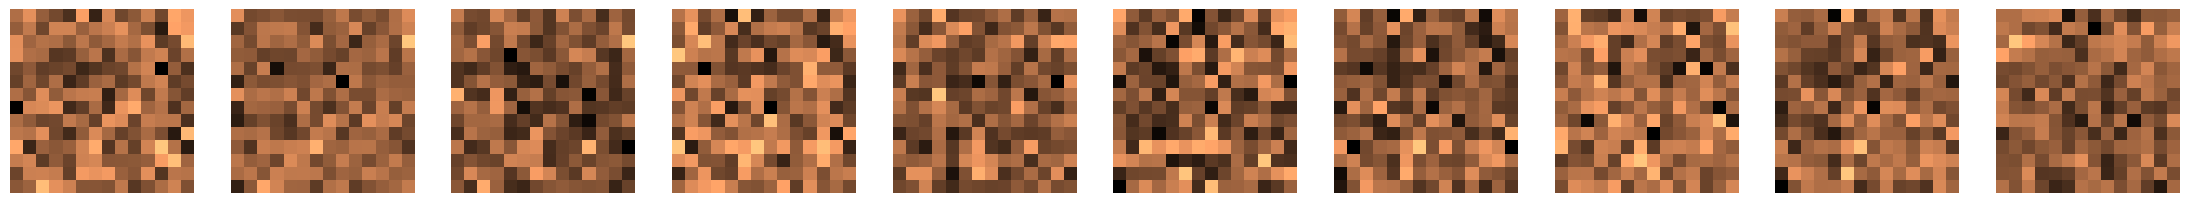

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - c_gp: 0.0163 - c_loss: 0.1411 - c_wass_loss: -0.0060 - g_loss: -0.0084
Epoch 22/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0166 - c_loss: 0.1436 - c_wass_loss: -0.0061 - g_loss: -0.0093
Epoch 23/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0159 - c_loss: 0.1367 - c_wass_loss: -0.0063 - g_loss: -0.0102
Epoch 24/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_gp: 0.0156 - c_loss: 0.1337 - c_wass_loss: -0.0063 - g_loss: -0.0109
Epoch 25/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0155 - c_loss: 0.1326 - c_wass_loss: -0.0065 - g_loss: -0.0119
Epoch 26/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_gp: 0.0147 - c_loss: 0.1255 - c_wass_loss: -0.0064 - g_loss: -0.0129
Epoch 27/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0144 - c_loss: 0.1232 - c_wass_loss: -0.0068 - g_loss: -0.0137
Epoch 28/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0141 - c_loss: 0.1198 - c_wass_loss: -0.0068 - g_loss: -0.0145
Epoch 29/150
5/5 ━━━━

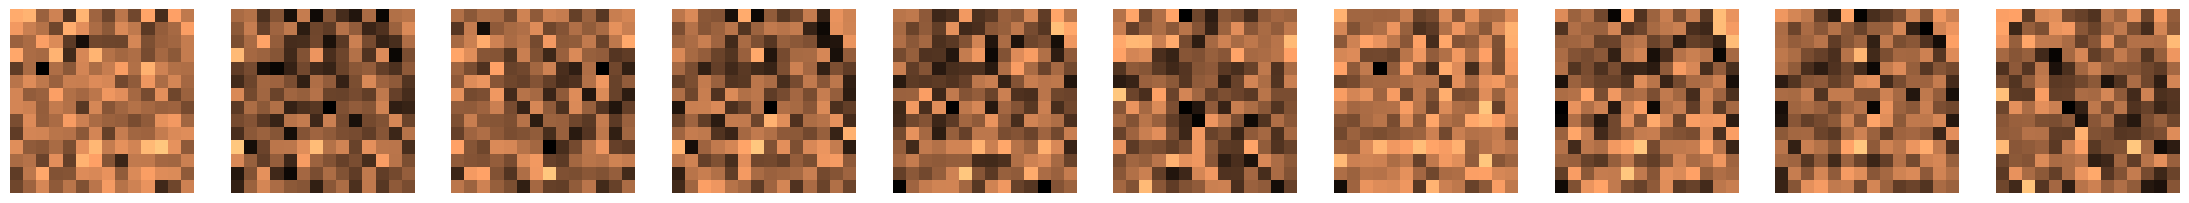

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - c_gp: 0.0136 - c_loss: 0.1147 - c_wass_loss: -0.0073 - g_loss: -0.0171
Epoch 32/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0141 - c_loss: 0.1194 - c_wass_loss: -0.0074 - g_loss: -0.0181
Epoch 33/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_gp: 0.0136 - c_loss: 0.1148 - c_wass_loss: -0.0076 - g_loss: -0.0186
Epoch 34/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0138 - c_loss: 0.1164 - c_wass_loss: -0.0076 - g_loss: -0.0194
Epoch 35/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_gp: 0.0129 - c_loss: 0.1080 - c_wass_loss: -0.0077 - g_loss: -0.0203
Epoch 36/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_gp: 0.0128 - c_loss: 0.1076 - c_wass_loss: -0.0080 - g_loss: -0.0209
Epoch 37/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0129 - c_loss: 0.1077 - c_wass_loss: -0.0084 - g_loss: -0.0217
Epoch 38/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0120 - c_loss: 0.0991 - c_wass_loss: -0.0085 - g_loss: -0.0223
Epoch 39/150
5/5 ━━━━

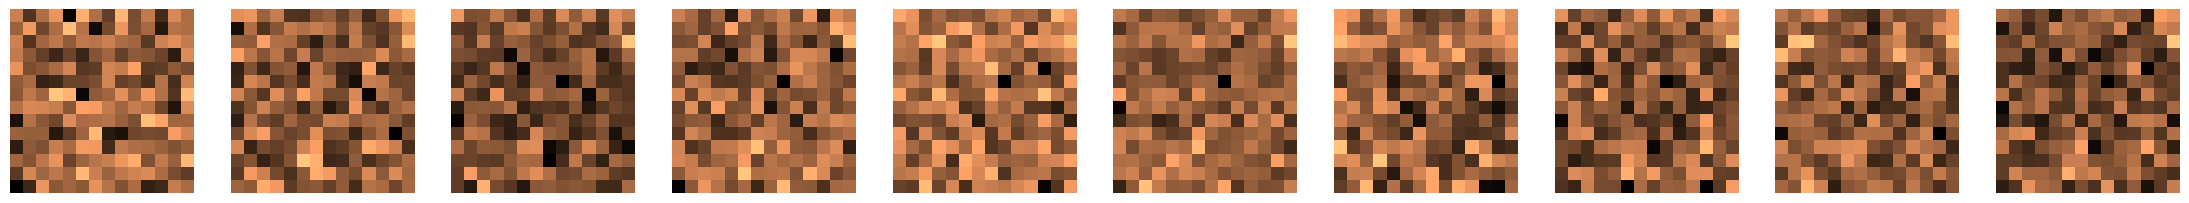

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - c_gp: 0.0129 - c_loss: 0.1067 - c_wass_loss: -0.0094 - g_loss: -0.0244
Epoch 42/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0123 - c_loss: 0.1017 - c_wass_loss: -0.0093 - g_loss: -0.0251
Epoch 43/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0123 - c_loss: 0.1012 - c_wass_loss: -0.0096 - g_loss: -0.0255
Epoch 44/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0119 - c_loss: 0.0976 - c_wass_loss: -0.0095 - g_loss: -0.0263
Epoch 45/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0117 - c_loss: 0.0952 - c_wass_loss: -0.0101 - g_loss: -0.0268
Epoch 46/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0122 - c_loss: 0.0991 - c_wass_loss: -0.0103 - g_loss: -0.0277
Epoch 47/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0117 - c_loss: 0.0947 - c_wass_loss: -0.0106 - g_loss: -0.0283
Epoch 48/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0116 - c_loss: 0.0929 - c_wass_loss: -0.0113 - g_loss: -0.0287
Epoch 49/150
5/5 ━━━━

2024-09-17 17:55:47.344725: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15979104858406314539


3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0119 - c_loss: 0.0949 - c_wass_loss: -0.0118 - g_loss: -0.0308

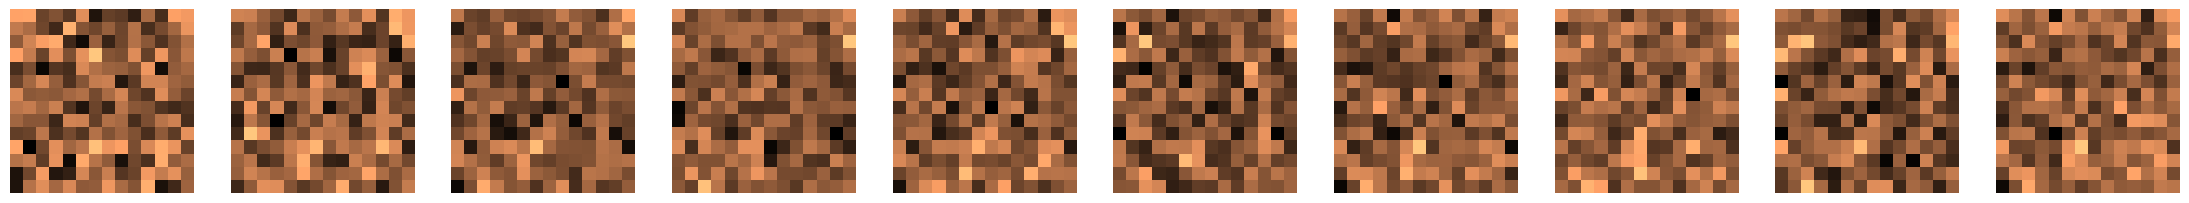

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - c_gp: 0.0119 - c_loss: 0.0950 - c_wass_loss: -0.0118 - g_loss: -0.0308
Epoch 52/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0110 - c_loss: 0.0865 - c_wass_loss: -0.0120 - g_loss: -0.0315
Epoch 53/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0108 - c_loss: 0.0851 - c_wass_loss: -0.0120 - g_loss: -0.0320
Epoch 54/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0108 - c_loss: 0.0850 - c_wass_loss: -0.0125 - g_loss: -0.0325
Epoch 55/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - c_gp: 0.0114 - c_loss: 0.0897 - c_wass_loss: -0.0125 - g_loss: -0.0331

2024-09-17 17:55:47.923899: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15979104858406314539


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0110 - c_loss: 0.0864 - c_wass_loss: -0.0126 - g_loss: -0.0331
Epoch 56/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0118 - c_loss: 0.0933 - c_wass_loss: -0.0126 - g_loss: -0.0337
Epoch 57/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0110 - c_loss: 0.0859 - c_wass_loss: -0.0130 - g_loss: -0.0341
Epoch 58/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0108 - c_loss: 0.0845 - c_wass_loss: -0.0129 - g_loss: -0.0347
Epoch 59/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0102 - c_loss: 0.0786 - c_wass_loss: -0.0130 - g_loss: -0.0356
Epoch 60/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_gp: 0.0102 - c_loss: 0.0790 - c_wass_loss: -0.0132 - g_loss: -0.0360
Epoch 61/150
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - c_gp: 0.0102 - c_loss: 0.0784 - c_wass_loss: -0.0132 - g_loss: -0.0365

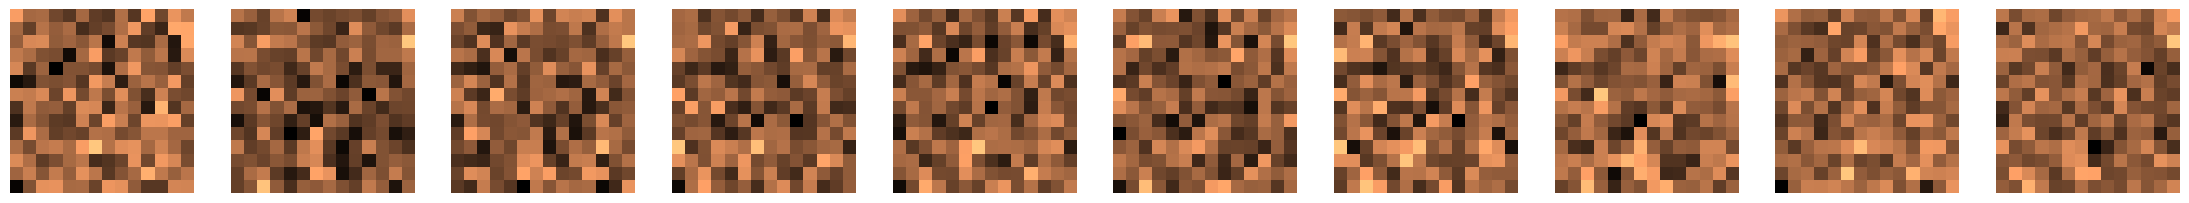

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - c_gp: 0.0101 - c_loss: 0.0779 - c_wass_loss: -0.0131 - g_loss: -0.0365
Epoch 62/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0103 - c_loss: 0.0795 - c_wass_loss: -0.0133 - g_loss: -0.0371
Epoch 63/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0105 - c_loss: 0.0812 - c_wass_loss: -0.0136 - g_loss: -0.0373
Epoch 64/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0101 - c_loss: 0.0777 - c_wass_loss: -0.0136 - g_loss: -0.0377

2024-09-17 17:55:49.107815: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15979104858406314539


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_gp: 0.0101 - c_loss: 0.0770 - c_wass_loss: -0.0138 - g_loss: -0.0379
Epoch 65/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0104 - c_loss: 0.0792 - c_wass_loss: -0.0139 - g_loss: -0.0382
Epoch 66/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0107 - c_loss: 0.0819 - c_wass_loss: -0.0140 - g_loss: -0.0387
Epoch 67/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0097 - c_loss: 0.0732 - c_wass_loss: -0.0143 - g_loss: -0.0394
Epoch 68/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0100 - c_loss: 0.0760 - c_wass_loss: -0.0141 - g_loss: -0.0399
Epoch 69/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0100 - c_loss: 0.0755 - c_wass_loss: -0.0144 - g_loss: -0.0403
Epoch 70/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0100 - c_loss: 0.0754 - c_wass_loss: -0.0144 - g_loss: -0.0408
Epoch 71/150
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - c_gp: 0.0095 - c_loss: 0.0714 - c_wass_loss: -0.0146 - g_loss: -0.0413

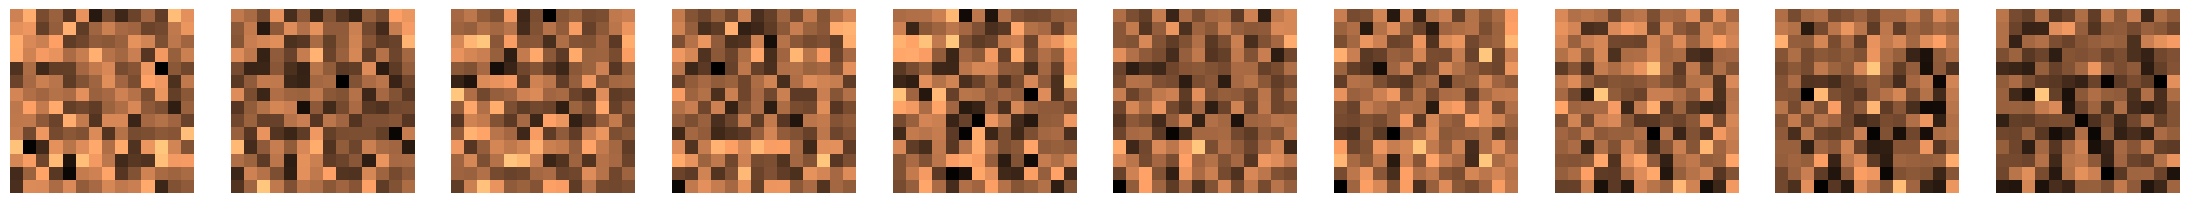

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - c_gp: 0.0096 - c_loss: 0.0716 - c_wass_loss: -0.0146 - g_loss: -0.0413
Epoch 72/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0101 - c_loss: 0.0764 - c_wass_loss: -0.0145 - g_loss: -0.0420
Epoch 73/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0095 - c_loss: 0.0707 - c_wass_loss: -0.0148 - g_loss: -0.0422
Epoch 74/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0095 - c_loss: 0.0709 - c_wass_loss: -0.0147 - g_loss: -0.0426
Epoch 75/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0093 - c_loss: 0.0684 - c_wass_loss: -0.0151 - g_loss: -0.0428
Epoch 76/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0094 - c_loss: 0.0694 - c_wass_loss: -0.0148 - g_loss: -0.0432
Epoch 77/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0096 - c_loss: 0.0710 - c_wass_loss: -0.0152 - g_loss: -0.0436
Epoch 78/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0095 - c_loss: 0.0702 - c_wass_loss: -0.0150 - g_loss: -0.0437
Epoch 79/150
5/5 ━━━━

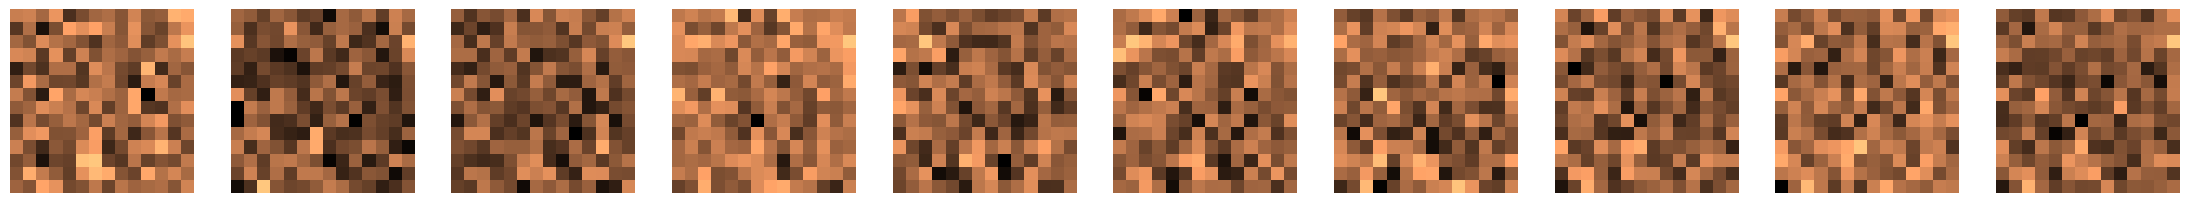

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - c_gp: 0.0099 - c_loss: 0.0734 - c_wass_loss: -0.0155 - g_loss: -0.0444
Epoch 82/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0096 - c_loss: 0.0704 - c_wass_loss: -0.0159 - g_loss: -0.0448
Epoch 83/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0096 - c_loss: 0.0705 - c_wass_loss: -0.0159 - g_loss: -0.0450
Epoch 84/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0091 - c_loss: 0.0659 - c_wass_loss: -0.0158 - g_loss: -0.0452
Epoch 85/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0100 - c_loss: 0.0740 - c_wass_loss: -0.0160 - g_loss: -0.0455
Epoch 86/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0092 - c_loss: 0.0666 - c_wass_loss: -0.0163 - g_loss: -0.0454
Epoch 87/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0088 - c_loss: 0.0627 - c_wass_loss: -0.0161 - g_loss: -0.0463
Epoch 88/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - c_gp: 0.0089 - c_loss: 0.0639 - c_wass_loss: -0.0163 - g_loss: -0.0465
Epoch 89/150
5/5 ━━━━

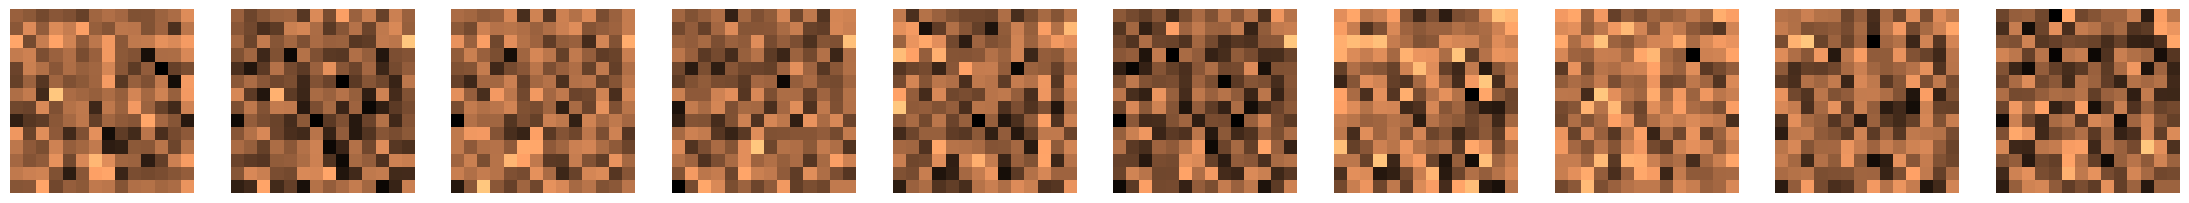

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - c_gp: 0.0087 - c_loss: 0.0621 - c_wass_loss: -0.0162 - g_loss: -0.0481
Epoch 92/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0091 - c_loss: 0.0658 - c_wass_loss: -0.0159 - g_loss: -0.0483
Epoch 93/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0090 - c_loss: 0.0652 - c_wass_loss: -0.0158 - g_loss: -0.0483
Epoch 94/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - c_gp: 0.0088 - c_loss: 0.0633 - c_wass_loss: -0.0162 - g_loss: -0.0487

2024-09-17 17:55:52.983506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15979104858406314539


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0091 - c_loss: 0.0655 - c_wass_loss: -0.0163 - g_loss: -0.0484
Epoch 95/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0090 - c_loss: 0.0651 - c_wass_loss: -0.0163 - g_loss: -0.0485
Epoch 96/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_gp: 0.0092 - c_loss: 0.0661 - c_wass_loss: -0.0165 - g_loss: -0.0487
Epoch 97/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0090 - c_loss: 0.0642 - c_wass_loss: -0.0167 - g_loss: -0.0489
Epoch 98/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0091 - c_loss: 0.0648 - c_wass_loss: -0.0167 - g_loss: -0.0494
Epoch 99/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0089 - c_loss: 0.0632 - c_wass_loss: -0.0169 - g_loss: -0.0498
Epoch 100/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0083 - c_loss: 0.0580 - c_wass_loss: -0.0169 - g_loss: -0.0499
Epoch 101/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - c_gp: 0.0088 - c_loss: 0.0628 - c_wass_loss: -0.0166 - g_loss: -0.0501

2024-09-17 17:55:53.822589: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15979104858406314539


3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - c_gp: 0.0087 - c_loss: 0.0619 - c_wass_loss: -0.0166 - g_loss: -0.0501

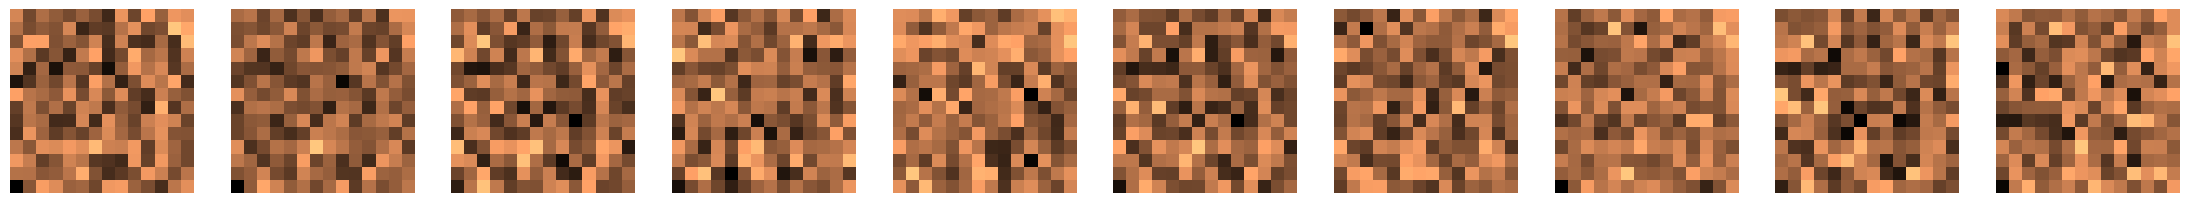

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - c_gp: 0.0087 - c_loss: 0.0618 - c_wass_loss: -0.0165 - g_loss: -0.0502
Epoch 102/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0090 - c_loss: 0.0644 - c_wass_loss: -0.0167 - g_loss: -0.0505
Epoch 103/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0091 - c_loss: 0.0652 - c_wass_loss: -0.0168 - g_loss: -0.0510
Epoch 104/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0088 - c_loss: 0.0629 - c_wass_loss: -0.0165 - g_loss: -0.0511
Epoch 105/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0092 - c_loss: 0.0664 - c_wass_loss: -0.0162 - g_loss: -0.0515
Epoch 106/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_gp: 0.0090 - c_loss: 0.0650 - c_wass_loss: -0.0165 - g_loss: -0.0515
Epoch 107/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - c_gp: 0.0085 - c_loss: 0.0600 - c_wass_loss: -0.0164 - g_loss: -0.0521
Epoch 108/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0091 - c_loss: 0.0648 - c_wass_loss: -0.0166 - g_loss: -0.0517
Epoch 109/150


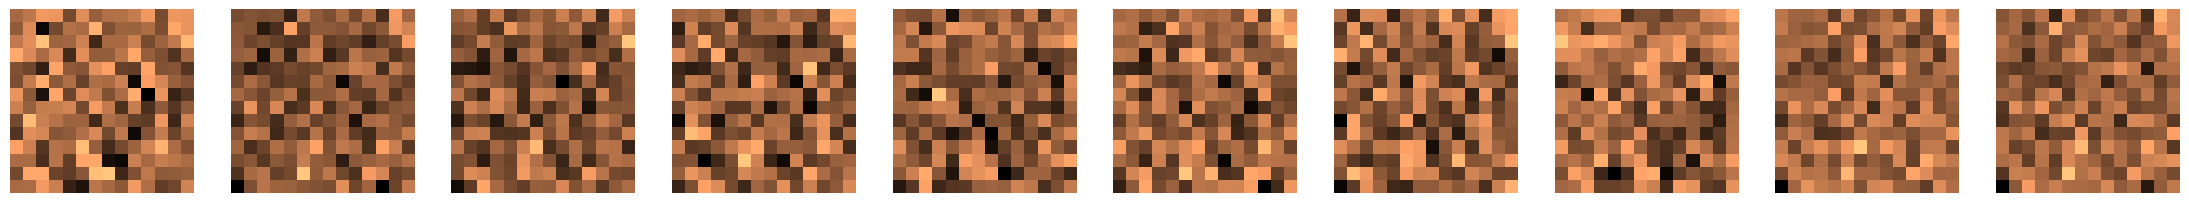

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - c_gp: 0.0086 - c_loss: 0.0607 - c_wass_loss: -0.0169 - g_loss: -0.0525
Epoch 112/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_gp: 0.0092 - c_loss: 0.0661 - c_wass_loss: -0.0165 - g_loss: -0.0525
Epoch 113/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - c_gp: 0.0084 - c_loss: 0.0585 - c_wass_loss: -0.0167 - g_loss: -0.0525
Epoch 114/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0086 - c_loss: 0.0607 - c_wass_loss: -0.0169 - g_loss: -0.0527
Epoch 115/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - c_gp: 0.0087 - c_loss: 0.0614 - c_wass_loss: -0.0170 - g_loss: -0.0528
Epoch 116/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - c_gp: 0.0085 - c_loss: 0.0594 - c_wass_loss: -0.0169 - g_loss: -0.0532
Epoch 117/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - c_gp: 0.0086 - c_loss: 0.0605 - c_wass_loss: -0.0168 - g_loss: -0.0536
Epoch 118/150
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - c_gp: 0.0083 - c_loss: 0.0587 - c_wass_loss: -0.0164 - g_loss: -0.0538

2024-09-17 17:55:56.089854: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 15979104858406314539


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0083 - c_loss: 0.0586 - c_wass_loss: -0.0165 - g_loss: -0.0537
Epoch 119/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0083 - c_loss: 0.0575 - c_wass_loss: -0.0169 - g_loss: -0.0539
Epoch 120/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0079 - c_loss: 0.0545 - c_wass_loss: -0.0169 - g_loss: -0.0538
Epoch 121/150
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - c_gp: 0.0081 - c_loss: 0.0569 - c_wass_loss: -0.0164 - g_loss: -0.0542

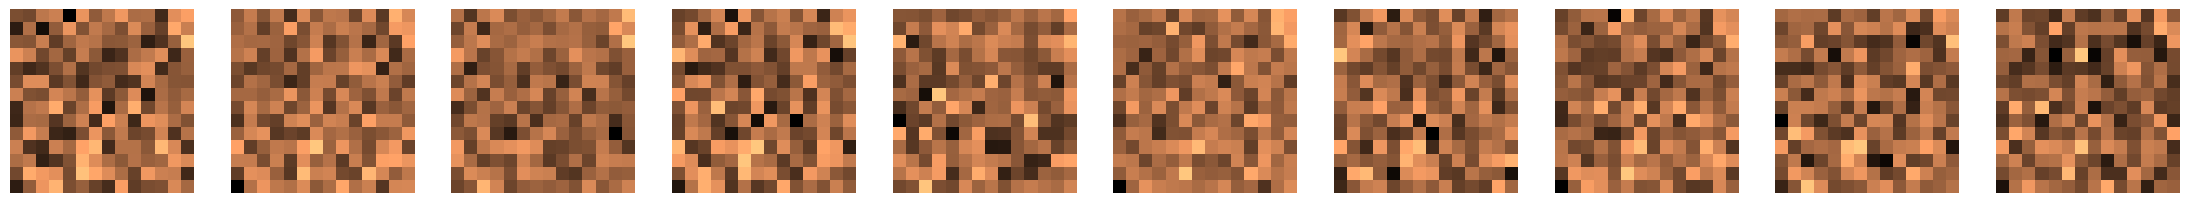

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - c_gp: 0.0082 - c_loss: 0.0570 - c_wass_loss: -0.0164 - g_loss: -0.0543
Epoch 122/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - c_gp: 0.0082 - c_loss: 0.0574 - c_wass_loss: -0.0166 - g_loss: -0.0552
Epoch 123/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0078 - c_loss: 0.0530 - c_wass_loss: -0.0168 - g_loss: -0.0551
Epoch 124/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0078 - c_loss: 0.0534 - c_wass_loss: -0.0168 - g_loss: -0.0554
Epoch 125/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0082 - c_loss: 0.0566 - c_wass_loss: -0.0169 - g_loss: -0.0554
Epoch 126/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0081 - c_loss: 0.0562 - c_wass_loss: -0.0170 - g_loss: -0.0555
Epoch 127/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0077 - c_loss: 0.0526 - c_wass_loss: -0.0168 - g_loss: -0.0557
Epoch 128/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0079 - c_loss: 0.0540 - c_wass_loss: -0.0171 - g_loss: -0.0558
Epoch 129/150


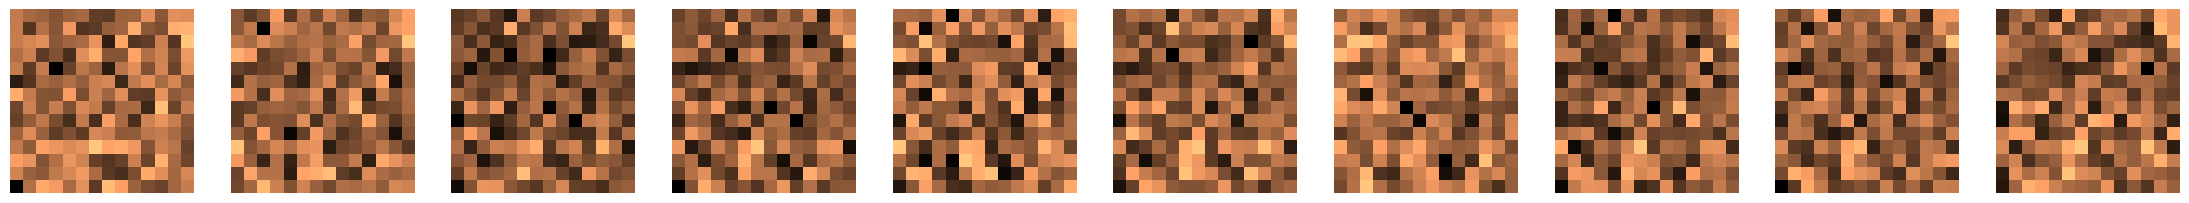

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - c_gp: 0.0077 - c_loss: 0.0526 - c_wass_loss: -0.0168 - g_loss: -0.0562
Epoch 132/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0082 - c_loss: 0.0570 - c_wass_loss: -0.0164 - g_loss: -0.0562
Epoch 133/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0081 - c_loss: 0.0561 - c_wass_loss: -0.0168 - g_loss: -0.0567
Epoch 134/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0077 - c_loss: 0.0528 - c_wass_loss: -0.0165 - g_loss: -0.0566
Epoch 135/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - c_gp: 0.0077 - c_loss: 0.0534 - c_wass_loss: -0.0162 - g_loss: -0.0569
Epoch 136/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0080 - c_loss: 0.0558 - c_wass_loss: -0.0162 - g_loss: -0.0572
Epoch 137/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0078 - c_loss: 0.0540 - c_wass_loss: -0.0163 - g_loss: -0.0576
Epoch 138/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0076 - c_loss: 0.0521 - c_wass_loss: -0.0165 - g_loss: -0.0574
Epoch 139/150


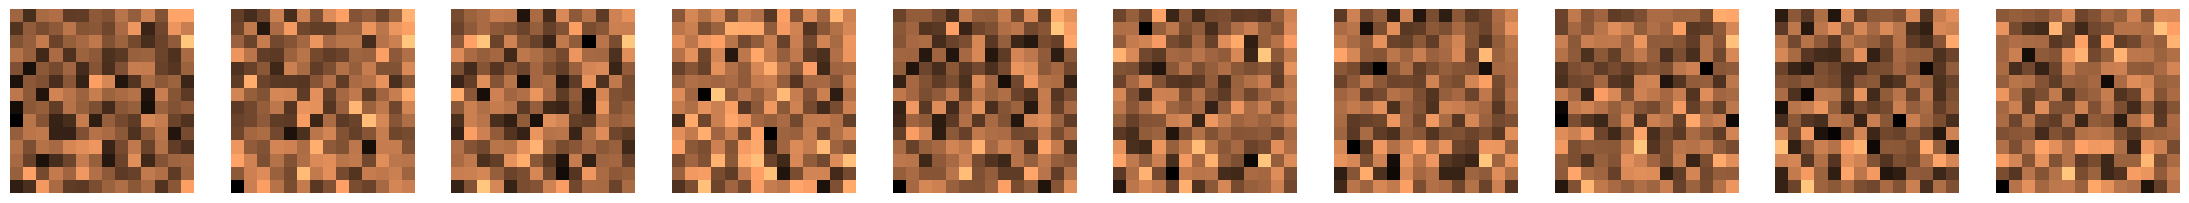

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - c_gp: 0.0078 - c_loss: 0.0531 - c_wass_loss: -0.0167 - g_loss: -0.0578
Epoch 142/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0077 - c_loss: 0.0529 - c_wass_loss: -0.0167 - g_loss: -0.0584
Epoch 143/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0079 - c_loss: 0.0546 - c_wass_loss: -0.0163 - g_loss: -0.0585
Epoch 144/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0078 - c_loss: 0.0535 - c_wass_loss: -0.0163 - g_loss: -0.0583
Epoch 145/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - c_gp: 0.0079 - c_loss: 0.0545 - c_wass_loss: -0.0165 - g_loss: -0.0583
Epoch 146/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - c_gp: 0.0078 - c_loss: 0.0538 - c_wass_loss: -0.0162 - g_loss: -0.0582
Epoch 147/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0079 - c_loss: 0.0547 - c_wass_loss: -0.0163 - g_loss: -0.0580
Epoch 148/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0078 - c_loss: 0.0532 - c_wass_loss: -0.0167 - g_loss: -0.0582
Epoch 149/150


In [343]:
if TRAIN:
    dataset = tf.data.Dataset.from_tensors(X.astype("float32")).repeat(REPEAT_DATA)

    wgangp.fit(
        dataset,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[
            ImageGenerator(latent_dim=Z_DIM),
        ],
    )

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


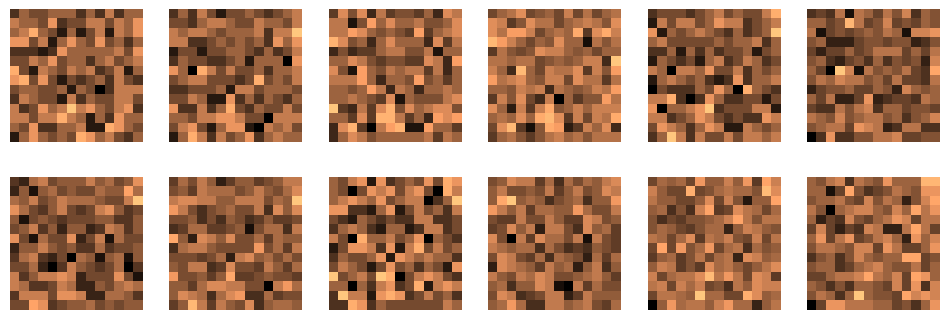

In [344]:
if TRAIN:
    
    noise = np.random.normal(size=(NUM_LANGS, Z_DIM))
    generated_language_parameters = generator.predict(noise)
    l = generated_language_parameters.shape[0]

    # normalise
    generated_language_parameters = (generated_language_parameters-np.min(generated_language_parameters))/(np.max(generated_language_parameters)-np.min(generated_language_parameters))

    # weirdness
    mean_lang = np.mean(X, axis=0).reshape(-1)
    diff_from_mean = np.array([np.mean(np.abs(mean_lang - g)) for g in generated_language_parameters])
    weirdness = np.round((diff_from_mean-np.min(diff_from_mean))/(np.max(diff_from_mean)-np.min(diff_from_mean)), decimals=2)

    np.savez_compressed(
        "./data/generated_language_parameters.npz",
        generated_language_parameters=generated_language_parameters,
        weirdness=weirdness
    )

else:
    data = np.load("./data/generated_language_parameters.npz", allow_pickle=True)
    generated_language_parameters = data["generated_language_parameters"]
    weirdness = data["weirdness"]
    l = generated_language_parameters.shape[0]

generated = (generated_language_parameters * MAX_VALUE).astype(int)

display_rows(generated, cmap="copper_r", r=2, c=6, size=(12, 4))

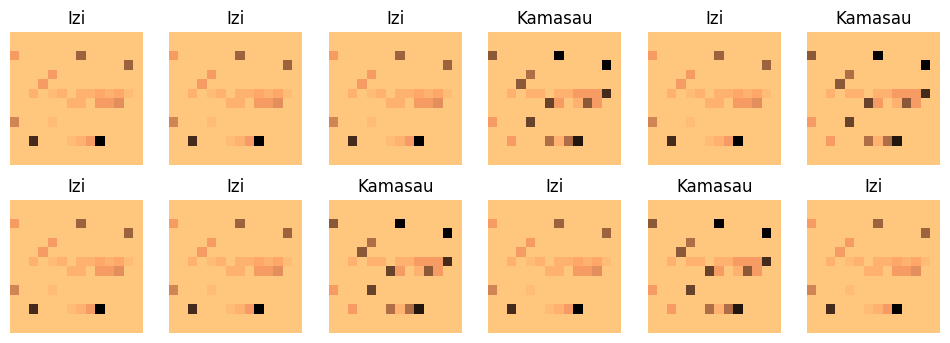

10.486836734693878

In [345]:
# find closest matches
origin = (X * MAX_VALUE).astype(int)

closest_idx, closest, closest_diff = get_closest_matches(origin, generated, n=NUM_LANGS)
closest_language_names = np.take(languages[:, 1], closest_idx)

display_rows(closest, titles=closest_language_names, cmap="copper_r", r=2, c=6, size=(12, 4))

np.mean(closest_diff)

In [346]:
# find exact matches

exact_idx = get_exact_matches_indices(origin, generated)
exact = np.take(X, exact_idx)
exact_language_names = np.take(languages[:, 1], exact_idx)

if len(exact_idx) > 0:
    display_rows(exact, titles=exact_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))
else:
    print("No exact matches. Noice!")

origin.shape, exact_idx.shape

No exact matches. Noice!


((1021, 14, 14, 1), (0,))

In [347]:
from cldfbench import get_dataset

wals = get_dataset("wals").cldf_reader()

param_df = (
    pd.DataFrame(wals.iter_rows("ParameterTable"))
    .set_index(["Area", "Chapter"])
    .drop(columns=["Description", "Contributor_ID"])
)

param_df = param_df[
    ~param_df.index.get_level_values("Area").isin(["Sign Languages", "Other"])
]

param_df.head(5)

ID  \
Area      Chapter                                   
Phonology Consonant Inventories                1A   
          Vowel Quality Inventories            2A   
          Consonant-Vowel Ratio                3A   
          Voicing in Plosives and Fricatives   4A   
          Voicing and Gaps in Plosive Systems  5A   

                                                                              Name  
Area      Chapter                                                                   
Phonology Consonant Inventories                              Consonant Inventories  
          Vowel Quality Inventories                      Vowel Quality Inventories  
          Consonant-Vowel Ratio                              Consonant-Vowel Ratio  
          Voicing in Plosives and Fricatives    Voicing in Plosives and Fricatives  
          Voicing and Gaps in Plosive Systems  Voicing and Gaps in Plosive Systems